# Outlier dimensions

In [15]:
import ast
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel

DATA_PATH = "data/en_ewt-ud-train_sentences.csv"
MAX_SENTENCES = 10000               
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MODELS = [
    {"name": "bert-base-uncased", "pooling": "first"},
    {"name": "gpt2", "pooling": "last"},
]
FIGSIZE = (8, 4)
SAVE_FIG = False
FIG_PATH = "outlier_dims.png"

In [16]:
df = pd.read_csv(DATA_PATH)

In [17]:
def _parse_tokens(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        x = x.strip()
        if x.startswith("[") and x.endswith("]"):
            return ast.literal_eval(x)
        return x.split()
    raise TypeError(f"Unsupported tokens type: {type(x)}")

sentences = [ _parse_tokens(x) for x in df["tokens"].tolist() ]
if MAX_SENTENCES is not None:
    sentences = sentences[:MAX_SENTENCES]

print(f"Loaded {len(sentences)} sentences")

Loaded 10000 sentences


In [18]:
def layerwise_mean_activation(
    sentences,
    model_name: str,
    pooling: str = "first",   
    device: str = "cpu",
    max_length: int = 512,
):
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, add_prefix_space=True)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()

    layer_sum = None   # (L, D) float64
    n_words_total = 0

    with torch.no_grad():
        for words in sentences:
            enc = tokenizer(
                words,
                is_split_into_words=True,
                return_tensors="pt",
                truncation=True,
                max_length=max_length,
            )
            word_ids = enc.word_ids(batch_index=0)
            enc = enc.to(device)

            out = model(**enc, output_hidden_states=True)
            hidden_states = out.hidden_states  # tuple of length L; each (1, T, D)

            if layer_sum is None:
                L = len(hidden_states)
                D = hidden_states[0].shape[-1]
                layer_sum = np.zeros((L, D), dtype=np.float64)

            word_pos = {}
            for tok_i, wid in enumerate(word_ids):
                if wid is None:
                    continue
                if pooling == "first":
                    word_pos.setdefault(wid, tok_i)
                elif pooling == "last":
                    word_pos[wid] = tok_i
                else:
                    raise ValueError("pooling must be 'first' or 'last' in this demo")

            max_wid = max(word_pos.keys()) if word_pos else -1
            positions = [word_pos[i] for i in range(max_wid + 1) if i in word_pos]
            if not positions:
                continue

            for l, hs in enumerate(hidden_states):
                sel = hs[0, positions, :]          # (W, D)
                layer_sum[l] += sel.sum(dim=0).detach().cpu().numpy()

            n_words_total += len(positions)

    layer_mean = layer_sum / max(n_words_total, 1)
    return layer_mean  

In [19]:
def outlier_dims_from_layer_means(layer_means: np.ndarray, z: float = 3.0):
    # layer_means: (L, D)
    flat = layer_means.reshape(-1)
    mu = float(flat.mean())
    sigma = float(flat.std(ddof=0))
    thr = mu + z * sigma

    outlier_mask = layer_means >= thr 
    outlier_counts = outlier_mask.sum(axis=1)  # (L,)

    overlap_prev = np.zeros_like(outlier_counts)
    overlap_prev[1:] = (outlier_mask[1:] & outlier_mask[:-1]).sum(axis=1)

    exceed = np.maximum(0.0, layer_means - thr)
    mean_exceed = np.zeros(layer_means.shape[0], dtype=np.float64)
    for l in range(layer_means.shape[0]):
        if outlier_counts[l] > 0:
            mean_exceed[l] = exceed[l][outlier_mask[l]].mean()

    return {"mu": mu, "sigma": sigma, "thr": thr,
            "mask": outlier_mask, "counts": outlier_counts,
            "overlap_prev": overlap_prev, "mean_exceed": mean_exceed}

In [20]:
results = []

for cfg in MODELS:
    name = cfg["name"]
    pooling = cfg["pooling"]
    print(f"Running: {name} ({pooling})")

    layer_means = layerwise_mean_activation(
        sentences,
        model_name=name,
        pooling=pooling,
        device=DEVICE,
    )
    stats = outlier_dims_from_layer_means(layer_means, z=3.0)
    stats["model"] = name
    stats["pooling"] = pooling
    stats["n_layers"] = layer_means.shape[0]
    stats["hidden_size"] = layer_means.shape[1]
    results.append(stats)

    print(f"  layers={stats['n_layers']}  hidden={stats['hidden_size']}  thr={stats['thr']:.4f}")

Running: bert-base-uncased (first)
  layers=13  hidden=768  thr=0.9567
Running: gpt2 (last)
  layers=13  hidden=768  thr=19.7691


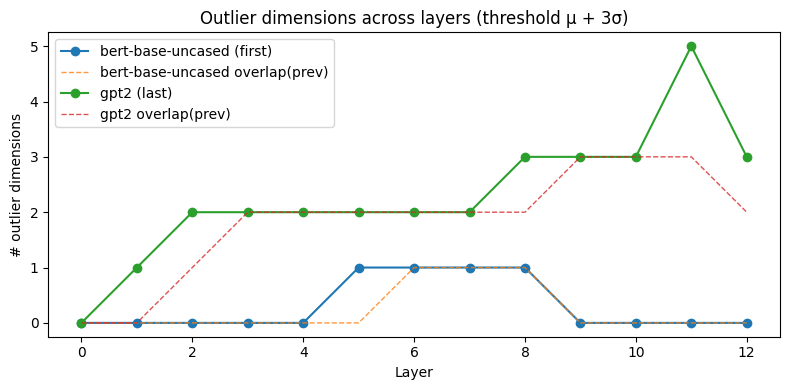

In [21]:
plt.figure(figsize=FIGSIZE)

for r in results:
    L = r["n_layers"]
    x = np.arange(L)
    plt.plot(x, r["counts"], marker="o", linewidth=1.5, label=f"{r['model']} ({r['pooling']})")
    plt.plot(x, r["overlap_prev"], linestyle="--", linewidth=1.0, alpha=0.8,
             label=f"{r['model']} overlap(prev)")

plt.xlabel("Layer")
plt.ylabel("# outlier dimensions")
plt.title("Outlier dimensions across layers (threshold μ + 3σ)")
plt.legend(loc="best")
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(FIG_PATH, dpi=200)
    print(f"Saved: {FIG_PATH}")

plt.show()